Preparamos Colab para trabajar con R

In [2]:
%%bash
apt-get install -y r-base


Reading package lists...
Building dependency tree...
Reading state information...
r-base is already the newest version (4.5.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [3]:
%load_ext rpy2.ipython

Descargamos el dataset


In [4]:
%%shell
mkdir -p ~/.kaggle
cp /content/sample_data/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [5]:
%%shell
pip install kaggle

In [6]:
%%shell
kaggle datasets download nisargpatel344/student-course-completion-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/nisargpatel344/student-course-completion-prediction-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/4.37M [00:00<?, ?B/s]
100% 4.37M/4.37M [00:00<00:00, 541MB/s]


In [7]:
%%R
system("unzip -o /content/student-course-completion-prediction-dataset.zip -d /content/")
df = read.csv("/content/Course_Completion_Prediction.csv")
head(df, 10)

   Student_ID            Name Gender Age Education_Level Employment_Status
1   STU100000    Vihaan Patel   Male  19         Diploma           Student
2   STU100001      Arjun Nair Female  17        Bachelor           Student
3   STU100002 Aditya Bhardwaj Female  34          Master           Student
4   STU100003   Krishna Singh Female  29         Diploma          Employed
5   STU100004    Krishna Nair Female  19          Master     Self-Employed
6   STU100005     Rohan Reddy Female  21        Bachelor           Student
7   STU100006        Sai Nair   Male  22         Diploma          Employed
8   STU100007   Krishna Desai   Male  23          Master          Employed
9   STU100008    Vihaan Joshi   Male  17        Bachelor           Student
10  STU100009     Vivaan Nair   Male  32        Bachelor           Student
        City Device_Type Internet_Connection_Quality Course_ID
1     Indore      Laptop                      Medium      C102
2      Delhi      Laptop                         

EDA

Dimensiones del dataset

In [8]:
%%R
dim(df)


[1] 100000     40


Tipos de datos

In [9]:
%%R
str(df)


'data.frame':	100000 obs. of  40 variables:
 $ Student_ID                  : chr  "STU100000" "STU100001" "STU100002" "STU100003" ...
 $ Name                        : chr  "Vihaan Patel" "Arjun Nair" "Aditya Bhardwaj" "Krishna Singh" ...
 $ Gender                      : chr  "Male" "Female" "Female" "Female" ...
 $ Age                         : int  19 17 34 29 19 21 22 23 17 32 ...
 $ Education_Level             : chr  "Diploma" "Bachelor" "Master" "Diploma" ...
 $ Employment_Status           : chr  "Student" "Student" "Student" "Employed" ...
 $ City                        : chr  "Indore" "Delhi" "Chennai" "Surat" ...
 $ Device_Type                 : chr  "Laptop" "Laptop" "Mobile" "Mobile" ...
 $ Internet_Connection_Quality : chr  "Medium" "Low" "Medium" "High" ...
 $ Course_ID                   : chr  "C102" "C106" "C101" "C105" ...
 $ Course_Name                 : chr  "Data Analysis with Python" "Machine Learning A-Z" "Python Basics" "UI/UX Design Fundamentals" ...
 $ Category   

Resúmen estadístico

In [10]:
%%R
summary(df)


  Student_ID            Name              Gender               Age       
 Length:100000      Length:100000      Length:100000      Min.   :17.00  
 Class :character   Class :character   Class :character   1st Qu.:21.00  
 Mode  :character   Mode  :character   Mode  :character   Median :25.00  
                                                          Mean   :25.71  
                                                          3rd Qu.:30.00  
                                                          Max.   :52.00  
 Education_Level    Employment_Status      City           Device_Type       
 Length:100000      Length:100000      Length:100000      Length:100000     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                    

Revisar valores faltantes

In [11]:
%%R
colSums(is.na(df))


                  Student_ID                         Name 
                           0                            0 
                      Gender                          Age 
                           0                            0 
             Education_Level            Employment_Status 
                           0                            0 
                        City                  Device_Type 
                           0                            0 
 Internet_Connection_Quality                    Course_ID 
                           0                            0 
                 Course_Name                     Category 
                           0                            0 
                Course_Level         Course_Duration_Days 
                           0                            0 
           Instructor_Rating              Login_Frequency 
                           0                            0 
Average_Session_Duration_Min        Video_Completion_Rat

Distribución de la variable objetivo

In [12]:
%%R
table(df$Completed)



    Completed Not Completed 
        49030         50970 


Feature Engineering

Conversión de datos


In [13]:
%%R
library(dplyr)
library(lubridate)
# --- 1. Convertir la variable objetivo a binaria ---
df <- df %>%
  mutate(
    Completed = ifelse(Completed == "Completed", 1, 0)
  )

head(df$Completed, 10)

# --- 2. Convertir Enrollment_Date a formato fecha ---
df <- df %>%
  mutate(
    Enrollment_Date = dmy(Enrollment_Date)
  )

head(df$Enrollment_Date, 10)


 [1] "2024-06-01" "2025-04-27" "2024-01-20" "2025-05-13" "2024-12-19"
 [6] "2023-10-23" "2024-03-24" "2024-11-09" "2024-07-13" "2024-11-07"



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



In [14]:
%%R
# --- 3. Antigüedad del alumno en la plataforma ---
df <- df %>%
  mutate(
    Months_Active = round(time_length(interval(Enrollment_Date, Sys.Date()), "month"), 1)
  )

head(df$Months_Active, 10)

 [1] 18.5  7.6 22.9  7.1 11.9 25.8 20.7 13.2 17.1 13.3


In [15]:
%%R
# --- 4. Motivación total ---
df <- df %>%
  mutate(
    Total_Engagement = round(
      Login_Frequency +
      (Average_Session_Duration_Min / 10) +
      (Video_Completion_Rate / 20) +
      Discussion_Participation +
      Peer_Interaction_Score +
      (Time_Spent_Hours / 2) +
      Notifications_Checked +
      (App_Usage_Percentage / 10),
      1
    )
  )

head(df$Total_Engagement, 10)


 [1] 26.2 35.8 33.1 32.2 34.8 43.8 40.8 32.6 36.2 30.0


In [16]:
%%R
# --- 5. Ratio de tareas entregadas ---
df <- df %>%
  mutate(
    Assignment_Ratio = round(
      100 * df$Assignments_Submitted /
      (df$Assignments_Submitted + df$Assignments_Missed + 1),
      1
    )
  )

head(df$Assignment_Ratio, 10)


 [1] 80.0 36.4 72.7  0.0 45.5 63.6 27.3 63.6 90.9 27.3


In [17]:
%%R
# --- 6. Éxito aproximado en quizzes ---
df <- df %>%
  mutate(
    Quiz_Success_Rate = round(df$Quiz_Score_Avg, 1)
  )

head(df$Quiz_Success_Rate, 10)

 [1]  80.9  78.4 100.0  59.1  84.8  99.6  74.4  76.3  76.3  55.8


In [18]:
%%R
# --- 7. Rendimiento académico global ---
df <- df %>%
  mutate(
    Overall_Performance = round(
      0.4 * df$Quiz_Score_Avg +
      0.4 * df$Project_Grade +
      0.2 * df$Progress_Percentage,
      1
    )
  )

head(df$Overall_Performance, 10)


 [1] 75.0 59.5 90.9 49.1 84.1 81.1 72.9 74.4 76.7 52.5


In [19]:
%%R

# --- 8. Riesgo por inactividad ---
df <- df %>%
  mutate(
    Inactivity_Risk = round(
      100 * df$Days_Since_Last_Login /
      (df$Days_Since_Last_Login + df$Login_Frequency + 1),
      1
    )
  )

head(df$Inactivity_Risk, 10)



 [1] 20.0 37.5 76.0 86.4 57.1 33.3  0.0 10.0 20.0  0.0


In [20]:
%%R
# --- 9. Columnas binarias de pago y descuento ---
df <- df %>%
  mutate(
    Discount_Used = ifelse(Discount_Used == "Yes", 1, 0),
    Fee_Paid = ifelse(Fee_Paid == "Yes", 1, 0)
  )

head(df[, c("Discount_Used", "Fee_Paid")], 10)

   Discount_Used Fee_Paid
1              0        0
2              0        1
3              0        1
4              0        1
5              1        1
6              0        1
7              0        1
8              0        1
9              1        1
10             1        1


In [21]:
%%R
# --- 10. Mapeo del nivel del curso ---
df <- df %>%
  mutate(
    Course_Level = case_when(
      Course_Level == "Beginner" ~ 1,
      Course_Level == "Intermediate" ~ 2,
      Course_Level == "Advanced" ~ 3,
      TRUE ~ 2
    )
  )

head(df$Course_Level, 10)

 [1] 2 3 1 1 3 2 2 1 2 1


In [22]:
%%R
# --- 11. Puntuación de interacción técnica ---
df <- df %>%
  mutate(
    Platform_Interaction_Index = round(
      df$Rewatch_Count +
      df$Reminder_Emails_Clicked +
      df$Support_Tickets_Raised,
      1
    )
  )

head(df$Platform_Interaction_Index, 10)

 [1]  7  2  3  9  7 12  3  3  8  3


In [23]:
%%R
# --- 12. Puntuación estimada de motivación ---
df <- df %>%
  mutate(
    Motivation_Score = round(
      0.3 * df$Peer_Interaction_Score +
      0.3 * df$Discussion_Participation +
      0.4 * df$Satisfaction_Rating,
      1
    )
  )

head(df$Motivation_Score, 10)

 [1] 3.3 4.7 4.9 3.7 4.2 4.0 5.6 3.9 4.5 4.3


In [24]:
%%R
# --- 13. Horas de estudio ---
df <- df %>%
  mutate(
    Hours_Studied = round(
      df$Time_Spent_Hours + (df$Average_Session_Duration_Min / 60),
      1
    )
  )

head(df$Hours_Studied, 10)

 [1]  1.0  1.5  0.7  7.9  1.1 12.3  1.2  0.7  1.2  3.8


In [25]:
%%R
head(df, 10)

   Student_ID            Name Gender Age Education_Level Employment_Status
1   STU100000    Vihaan Patel   Male  19         Diploma           Student
2   STU100001      Arjun Nair Female  17        Bachelor           Student
3   STU100002 Aditya Bhardwaj Female  34          Master           Student
4   STU100003   Krishna Singh Female  29         Diploma          Employed
5   STU100004    Krishna Nair Female  19          Master     Self-Employed
6   STU100005     Rohan Reddy Female  21        Bachelor           Student
7   STU100006        Sai Nair   Male  22         Diploma          Employed
8   STU100007   Krishna Desai   Male  23          Master          Employed
9   STU100008    Vihaan Joshi   Male  17        Bachelor           Student
10  STU100009     Vivaan Nair   Male  32        Bachelor           Student
        City Device_Type Internet_Connection_Quality Course_ID
1     Indore      Laptop                      Medium      C102
2      Delhi      Laptop                         

# *VISUALIZACIÓN*


In [26]:
%%R
library(ggplot2)
library(dplyr)


Distribución de alumnos que completaron vs. no completaron

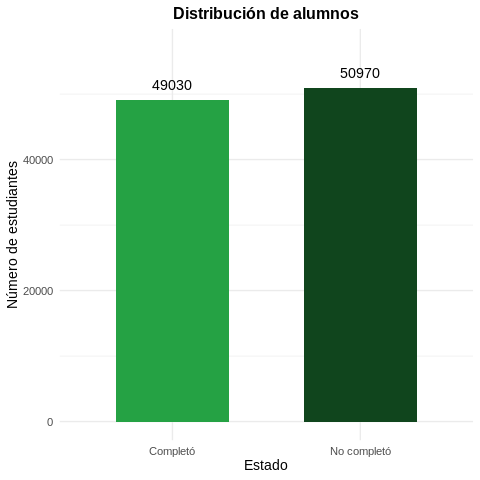

In [27]:
%%R

# Tabla de conteos y asegurar orden
comp_counts <- df %>%
  count(Completed) %>%
  mutate(
    Estado = ifelse(Completed == 1, "Completó", "No completó")
  ) %>%
  mutate(Estado = factor(Estado, levels = c("Completó", "No completó")))

# Paleta
palette_colors <- c(
  "Completó" = "#25a244ff",
  "No completó" = "#10451dff"
)

# Altura máxima para colocar etiquetas arriba y margen superior
max_n <- max(comp_counts$n)
label_y <- comp_counts$n + max_n * 0.03

# Gráfica con textos centrados
ggplot(comp_counts, aes(x = Estado, y = n, fill = Estado)) +
  geom_col(width = 0.6) +
  geom_text(aes(label = n, y = label_y),
            vjust = 0,
            hjust = 0.5,
            size = 5) +
  scale_fill_manual(values = palette_colors) +
  labs(
    title = "Distribución de alumnos",
    x = "Estado",
    y = "Número de estudiantes"
  ) +
  coord_cartesian(ylim = c(0, max_n * 1.12)) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.text.x = element_text(hjust = 0.5)
  )


Distribución de la edad de los estudiantes

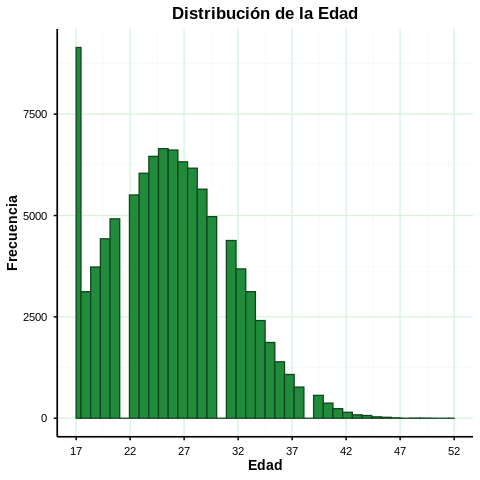

In [28]:
%%R

ggplot(df, aes(x = Age)) +
  geom_histogram(
    bins = 40,
    fill = "#208b3aff",
    color = "#10451dff",
    linewidth = 0.6
  ) +
  scale_x_continuous(
  limits = c(17, 52),
  breaks = seq(17, 52, 5),
  oob = scales::squish
) +
  labs(
    title = "Distribución de la Edad",
    x = "Edad",
    y = "Frecuencia"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", color = "black"),  # título centrado y negro
    panel.grid.major = element_line(color = "#d8f3dc"),                      # líneas de fondo claras
    panel.grid.minor = element_line(color = "#eaf7ee", linewidth = 0.2),
    axis.line = element_line(color = "black", linewidth = 0.8),              # ejes negros
    axis.ticks = element_line(color = "black", linewidth = 0.7),
    axis.text = element_text(color = "black"),
    axis.title = element_text(face = "bold", color = "black")
  )





Proporción de finalización por género

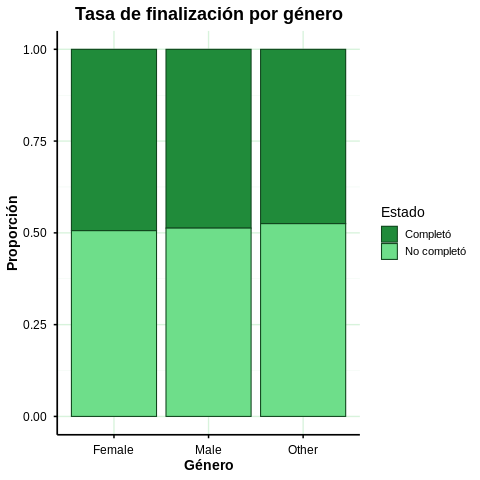

In [29]:
%%R
ggplot(
  df,
  aes(
    x = Gender,
    fill = factor(
      Completed,
      levels = c(1, 0),
      labels = c("Completó", "No completó")
    )
  )
) +
  geom_bar(position = "fill", color = "#10451dff", linewidth = 0.5) +
  scale_fill_manual(
    values = c(
      "Completó" = "#208b3aff",
      "No completó" = "#6ede8aff"
    )
  ) +
  labs(
    title = "Tasa de finalización por género",
    x = "Género",
    y = "Proporción",
    fill = "Estado"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", color = "black", size = 18),
    axis.title = element_text(face = "bold", color = "black", size = 14),
    axis.text = element_text(color = "black", size = 12),
    panel.grid.major = element_line(color = "#d8f3dc"),
    panel.grid.minor = element_line(color = "#eaf7ee", linewidth = 0.2),
    axis.line = element_line(color = "black", linewidth = 0.8),
    axis.ticks = element_line(color = "black", linewidth = 0.7)
  )



Distribución del desempeño global


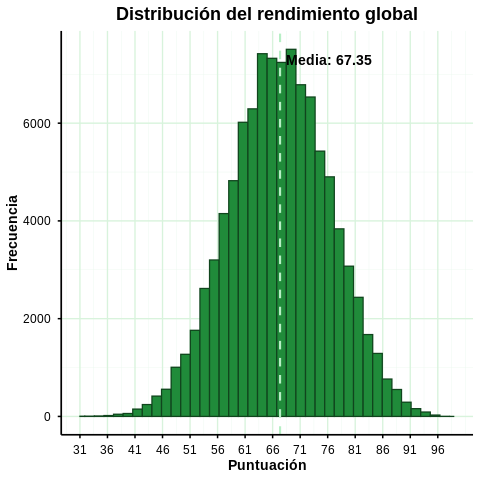

In [30]:
%%R
# Calcular la media
mean_perf <- mean(df$Overall_Performance, na.rm = TRUE)

# Ajustar límites del eje X ligeramente para que todos los valores entren
x_min <- floor(min(df$Overall_Performance, na.rm = TRUE))
x_max <- ceiling(max(df$Overall_Performance, na.rm = TRUE) + 1)

ggplot(df[!is.na(df$Overall_Performance), ], aes(x = Overall_Performance)) +
  geom_histogram(
    bins = 40,
    fill = "#208b3aff",
    color = "#10451dff",
    linewidth = 0.6
  ) +
  geom_vline(
    xintercept = mean_perf,
    color = "#b7efc5ff",
    linetype = "dashed",
    linewidth = 1
  ) +
  annotate(
    "text",
    x = mean_perf + 1,
    y = max(table(cut(df$Overall_Performance, breaks = 40))),
    label = paste0("Media: ", round(mean_perf, 2)),
    color = "black",
    fontface = "bold",
    hjust = 0
  ) +
  scale_x_continuous(
    limits = c(x_min, x_max),
    breaks = seq(x_min, x_max, 5),
    oob = scales::squish
  ) +
  labs(
    title = "Distribución del rendimiento global",
    x = "Puntuación",
    y = "Frecuencia"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", color = "black", size = 18),
    axis.title = element_text(face = "bold", color = "black", size = 14),
    axis.text = element_text(color = "black", size = 12),
    panel.grid.major = element_line(color = "#d8f3dc"),
    panel.grid.minor = element_line(color = "#eaf7ee", linewidth = 0.2),
    axis.line = element_line(color = "black", linewidth = 0.8),
    axis.ticks = element_line(color = "black", linewidth = 0.7)
  )

Comparación horas estudio - rendimiento

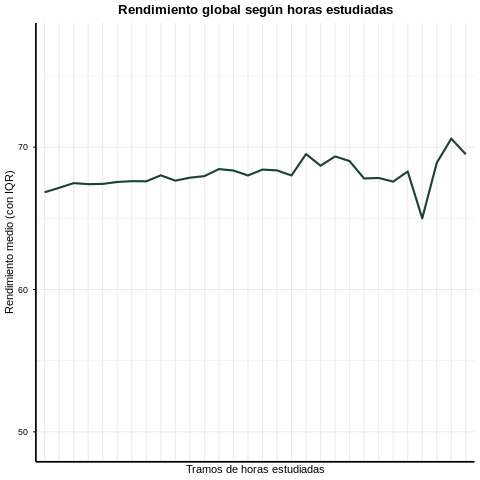

In [31]:
%%R
df %>%
  mutate(
    Hours_Bin = cut(Hours_Studied, breaks = 30)
  ) %>%
  group_by(Hours_Bin) %>%
  summarise(
    Mean_Performance = mean(Overall_Performance, na.rm = TRUE),
    P25 = quantile(Overall_Performance, 0.25, na.rm = TRUE),
    P75 = quantile(Overall_Performance, 0.75, na.rm = TRUE)
  ) %>%
  ggplot(aes(x = Hours_Bin, y = Mean_Performance)) +
  geom_line(group = 1, color = "#1b4332", linewidth = 1) +
  geom_ribbon(
    aes(ymin = P25, ymax = P75),
    fill = "#74c69d",
    alpha = 0.4
  ) +
  labs(
    title = "Rendimiento global según horas estudiadas",
    x = "Tramos de horas estudiadas",
    y = "Rendimiento medio (con IQR)"
  ) +
  theme_minimal() +
  theme(
    # Título centrado
    plot.title = element_text(hjust = 0.5, face = "bold"),

    # Ejes más oscuros
    axis.line = element_line(color = "black", linewidth = 0.8),
    axis.ticks = element_line(color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title = element_text(color = "black"),

    # Mantener X limpia
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank()
  )


Comparación de Motivation Score por género

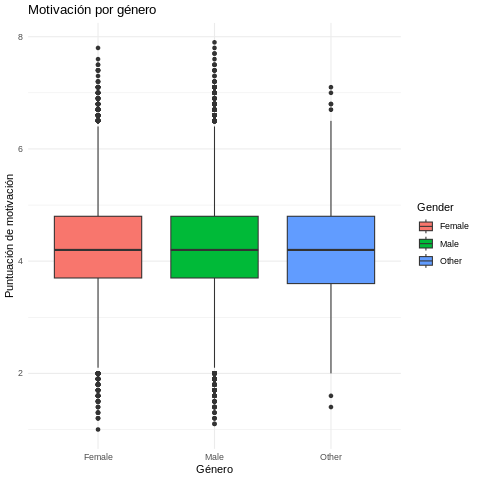

In [32]:
%%R
ggplot(df, aes(x = Gender, y = Motivation_Score, fill = Gender)) +
  geom_boxplot() +
  labs(title = "Motivación por género",
       x = "Género",
       y = "Puntuación de motivación") +
  theme_minimal()
# explicar gráfica

Motivation Score vs Performance

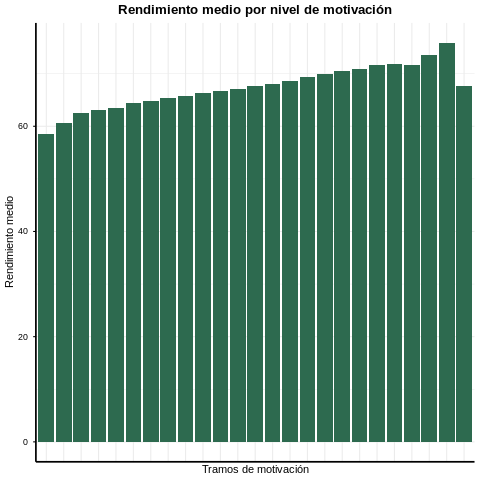

In [33]:
%%R
df %>%
  mutate(Motivation_Bin = cut(Motivation_Score, breaks = 25)) %>%
  group_by(Motivation_Bin) %>%
  summarise(
    Mean_Performance = mean(Overall_Performance, na.rm = TRUE)
  ) %>%
  ggplot(aes(x = Motivation_Bin, y = Mean_Performance)) +
  geom_col(fill = "#2d6a4f") +
  labs(
    title = "Rendimiento medio por nivel de motivación",
    x = "Tramos de motivación",
    y = "Rendimiento medio"
  ) +
  theme_minimal() +
  theme(
    # Centrar título
    plot.title = element_text(hjust = 0.5, face = "bold"),

    # Ejes más oscuros
    axis.line = element_line(color = "black", linewidth = 0.8),
    axis.ticks = element_line(color = "black"),
    axis.text.y = element_text(color = "black"),
    axis.title = element_text(color = "black"),

    axis.text.x = element_blank(),
    axis.ticks.x = element_blank()
  )



**Matriz de correlación**

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/corrplot_0.95.tar.gz'
Content type 'application/x-gzip' length 3745190 bytes (3.6 MB)
downloaded 3.6 MB


The downloaded source packages are in
	‘/tmp/Rtmp27koj5/downloaded_packages’


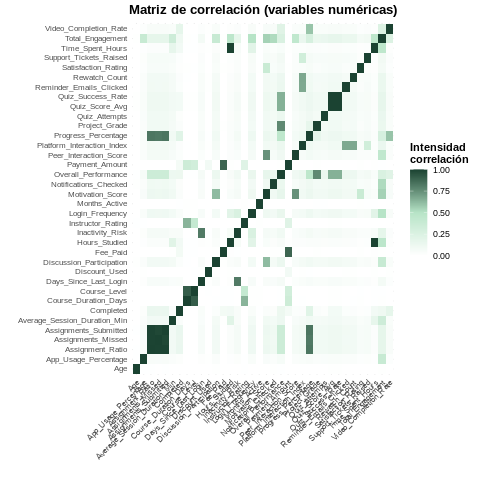

In [44]:
%%R
install.packages("corrplot", repos = "https://cloud.r-project.org")
library(dplyr)
library(tidyr)
library(tibble)

cor_mat <- df %>%
  select(where(is.numeric)) %>%
  cor(use = "complete.obs") %>%
  as.data.frame() %>%
  rownames_to_column("Var1") %>%
  pivot_longer(-Var1, names_to = "Var2", values_to = "Correlation")

ggplot(cor_mat, aes(Var1, Var2, fill = abs(Correlation))) +
  geom_tile() +
  scale_fill_gradientn(
    colours = c(
      "#ffffff",  # blanco
      "#b7e4c7",  # verde claro
      "#1b4332"   # verde oscuro
    ),
    limits = c(0, 1),
    name = "Intensidad\ncorrelación"
  ) +
  labs(
    title = "Matriz de correlación (variables numéricas)",
    x = "",
    y = ""
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(size = 8),
    legend.title = element_text(face = "bold")
  )

In [54]:
%%R
library(dplyr)
library(tibble)
library(knitr)

cor_completed <- df %>%
  select(where(is.numeric)) %>%
  cor(use = "complete.obs") %>%
  as.data.frame() %>%
  rownames_to_column("Variable") %>%
  select(Variable, Completed) %>%
  arrange(desc(abs(Completed)))


cor_completed %>%
  arrange(desc(abs(Completed))) %>%
  kable(
    caption = "Correlación de variables numéricas con Completed",
    digits = 3
  )



Table: Correlación de variables numéricas con Completed

|Variable                     | Completed|
|:----------------------------|---------:|
|Completed                    |     1.000|
|Progress_Percentage          |     0.214|
|Video_Completion_Rate        |     0.175|
|Assignments_Submitted        |     0.145|
|Assignment_Ratio             |     0.144|
|Assignments_Missed           |    -0.143|
|Overall_Performance          |     0.128|
|Total_Engagement             |     0.114|
|Hours_Studied                |     0.091|
|Time_Spent_Hours             |     0.090|
|Fee_Paid                     |     0.085|
|Quiz_Score_Avg               |     0.081|
|Quiz_Success_Rate            |     0.081|
|Payment_Amount               |     0.079|
|Inactivity_Risk              |    -0.049|
|Days_Since_Last_Login        |    -0.045|
|Login_Frequency              |     0.043|
|Motivation_Score             |     0.038|
|Average_Session_Duration_Min |     0.037|
|Project_Grade                |     0.